In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time

/Users/harihara/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Load and prepare the dataset

You will use the Brain Images - BraTS-2021 to train the generator and the discriminator. The generator will generate brain images resembling the brain data.

In [32]:
# Load dataset
brain_data = np.load(r"C:\Users\Kalyani\Documents\hari hara mini project\brain_data.npy_128128.npy")
print(brain_data.shape)

(10008, 128, 128)


In [33]:
brain_data = brain_data.reshape(10008, 128, 128, 1).astype('float32')
brain_data = (brain_data - 127.5) / 127.5  # Normalize to [-1, 1]
print(brain_data.shape)

(10008, 128, 128, 1)


In [ ]:
# Hyperparameters
BUFFER_SIZE = 10008
BATCH_SIZE = 32
LEARNING_RATE = 0.0002
EPOCHS = 750
Z_DIM = 256

In [35]:
# Prepare dataset
brain_data = (tf.data.Dataset.from_tensor_slices(brain_data)
    .shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
    )

## Create the models

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 128x128x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [36]:
def make_generator_model(z_dim):
    model = tf.keras.Sequential()

    # Dense to (8, 8, 512)
    model.add(layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(z_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 512)))  # (8, 8, 512)

    # (8 → 16)
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # (16 → 32)
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # (32 → 64)
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # (64 → 128)
    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Keep size at (128 × 128) and reduce channels to 1
    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model


Use the (as yet untrained) generator to create an image.

Generated Image Shape: (1, 128, 128, 1)


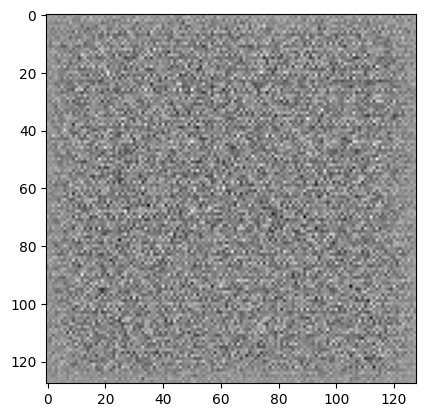

In [37]:
# Testing the generator with 256D noise
generator = make_generator_model(Z_DIM)
noise = tf.random.normal([1, Z_DIM])  # 256D noise
generated_image = generator(noise, training=False)

# Check output shape
print("Generated Image Shape:", generated_image.shape)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

### The Discriminator

The discriminator is a CNN-based image classifier.

In [38]:
import tensorflow as tf
from tensorflow.keras import layers

def make_discriminator_model():
    model = tf.keras.Sequential()

    # Input shape is now 128x128x1
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification: real/fake

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [39]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50004095]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [40]:
# Loss Functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [41]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [42]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [43]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [44]:
# Checkpointing
checkpoint_dir = './DC_GAN_240x240_Checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


## Define the training loop


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [45]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, Z_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

**Generate and save images**


In [49]:
# Image Generation
seed = tf.random.normal([4, Z_DIM])
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Training Loop 

In [50]:
from IPython.display import clear_output

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        clear_output(wait=True)  # ✅ Use clear_output directly
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    clear_output(wait=True)  # ✅ Use clear_output directly
    generate_and_save_images(generator, epochs, seed)

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look increasingly real.

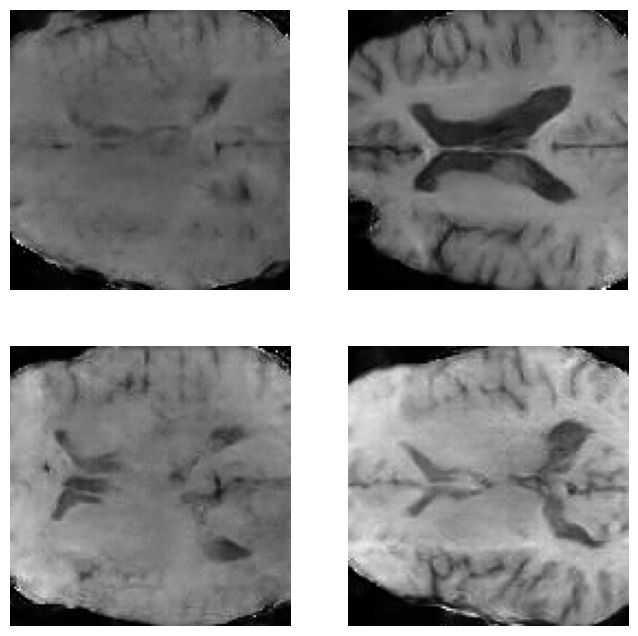

Time for epoch 312 is 10.610033750534058 sec


KeyboardInterrupt: 

In [57]:
train(brain_data, EPOCHS)

In [58]:
generator.save("generator_modelDCGAN-2_2.keras")

## Now Testing the Generator model on DICOM Images

Defining a function load_grayscale_image() which loads a DICOM image and converts it to grayscale with normalizing it to the range [-1, 1]. And Extract features from the image using the pre-trained ResNet50 model.

In [66]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.metrics import structural_similarity as ssim
from scipy.linalg import sqrtm
from tensorflow.keras.models import load_model

# --------- Load Trained Generator ---------
generator = load_model(r"C:\Users\Kalyani\Documents\hari hara mini project\DCGAN\generator_modelDCGAN-2.keras")

LATENT_DIM = 256
IMG_SHAPE = (128, 128, 1)

# --------- Step 1: Load Real Images from .npy File ---------
real_data_path = r"C:\Users\Kalyani\Documents\hari hara mini project\brain_data.npy_128128.npy"
real_images = np.load(real_data_path)

if real_images.ndim == 3:
    real_images = np.expand_dims(real_images, axis=-1)

# Normalize to [-1, 1] as used in training
real_images = (real_images.astype("float32") - 127.5) / 127.5

# Pick only N images for evaluation (e.g., 100)
N = 100
real_images = real_images[:N]

# --------- Step 2: Generate Fake Images ---------
noise = tf.random.normal([N, LATENT_DIM])
generated_images = generator(noise, training=False)

# --------- Step 3: Normalize for FID/SSIM ---------
# Scale from [-1, 1] → [0, 1]
real_images = (real_images + 1.0) / 2.0
generated_images = (generated_images + 1.0) / 2.0

# --------- Step 4a: Calculate SSIM ---------
def calculate_ssim(real, fake):
    scores = []
    for i in range(min(len(real), len(fake))):
        real_img = real[i].squeeze()
        fake_img = fake[i].numpy().squeeze()
        scores.append(ssim(real_img, fake_img, data_range=1.0))
    return np.max(scores)

ssim_score = calculate_ssim(real_images, generated_images)
print(f"SSIM Score: {ssim_score:.4f}")

SSIM Score: 0.5750
